# Computer Vision Project - Incisor Segmentation



## Jupyter Magics

In [37]:
%matplotlib inline

## load_landmarks.py - Load Landmarks

In [38]:
__author__ = 'david_torrejon & Bharath Venkatesh'
import os
import numpy as np
import string

def extractLandmarksForIncisorByIndex(landmarks,index):
    '''
    This function accepts landmarks as a dictionary
    indexed by radiogram number containing a list of list of points (check load_landmarks())
    For a given incisor index in [0,7] get a list of lists of all 
    landmarks for that incisor corresponding to each radiogram

    '''
    shapes=[]
    for key in landmarks.keys():
        shapes.append(landmarks[key][index])
    return shapes
    
def load_landmarks(path='./Project Data(2)/_Data/Landmarks/original/',mirrored=False):
    """
    x1
    y1
    x2
    y2
    ...
    xn
    yn
    returns a list of list of shapes (nb_docs, nb_points, 2)
    """
    all_=string.maketrans('','')
    nodigs=all_.translate(all_, string.digits)
    landmarks = {}
    ordering = {}

    if os.path.isdir(path):
        for filename in os.listdir(path):
            filepath = path+filename
            parts=filename.split("-") 
            key = parts[0].translate(all_, nodigs)
            #Need to remember the file index as well
            index=parts[1].translate(all_, nodigs)
            if mirrored:
                key=str(int(key)-14)
            #print key
            if key not in landmarks.keys():
                landmarks[key] = []
                ordering[key]=[]
            #print key
            ordering[key].append(index)
            with open(filepath) as fd:
                landmarks_file = []
                for i, line in enumerate(fd):
                    if i%2==0:
                        x = float(line)
                    else:
                        y = float(line)
                        landmarks_file.append([x,y])

                tmp = landmarks[key]
                #print landmarks
                landmarks[key].append(landmarks_file)
                #print landmarks[key]
    #print landmarks.keys()
    #Reordering each landmark list
    for key in landmarks.keys():
        #print ordering[key]
        myorder=sorted(range(len(ordering[key])), key=lambda k: ordering[key][k])
        #print myorder
        landmarks[key] = [ landmarks[key][i] for i in myorder]
    return landmarks


## load_images.py - Load Images

In [39]:
__author__ = 'david_torrejon & Bharath Venkatesh'

import cv2
import sys
import os
import numpy as np

def load_images(landmarks, path='./Project Data(2)/_Data/Radiographs/'):
    """
        shows an img, and its corresponding landmarks
    """
    img_landmark = {}
    matrix_images = []
    if os.path.isdir(path):
        for filename in os.listdir(path):
            filepath = path+filename
            if os.path.isfile(filepath):
                radiography_nb = int(filename.split(".")[0])
                #print radiography_nb
                landmark = landmarks[str(radiography_nb)]
                im = cv2.imread(filepath)
                gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
                for l in landmark:
                    pts = np.array(l, np.int32)
                    pts = pts.reshape((-1,1,2))
                    cv2.polylines(im,[pts],True,(0,255,255))
                img_landmark[str(radiography_nb)] = im
                #print type(im)
                #print gray.shape
                matrix_images.append(gray)
                #cv2.imshow(filename, im)
                #cv2.waitKey(0)
                #cv2.destroyAllWindows()
    return img_landmark, np.asarray(matrix_images)


## shape_utils.py - Common functions for shape handling

In [40]:
import math
import numpy as np
import matplotlib.pyplot as plt
import cv2
def show(img):
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

def convertShapeVectorIntoShape(shapeVector):
    return(np.reshape(shapeVector,(len(shapeVector)/2,2)).tolist())
    
def collapseShapeIntoList(shape):
    return np.reshape(np.array(shape),2*len(shape)).tolist()

def constructMatrixFromShapes(shapes):
    xvectors=[]
    for shape in shapes:
        xvectors.append(collapseShapeIntoList(shape))
    return np.array(xvectors)

def plotShapes(shapes):
    '''
    Utility to plot a list of shapes
    '''
    fig = plt.figure()
    ax = fig.add_subplot(111)
    for points in shapes:
        xlist,ylist=zip(*(points))
        ax.plot(xlist,ylist)
    plt.show()

def normalizeShape(l):
    '''
    Normalizes the shape and also returns the norm
    '''
    norm=np.linalg.norm(l)
    return l/norm,norm

def centerShape(l):
    '''
    Centers the shape by subtracting the mean and  also returns the mean
    '''
    mu=np.mean(l,axis=0)
    return l-mu,mu

def centerAndScaleShape(l):
    '''
    Centers the shape and scales it calling center and normalize
    also returns the mean and the norm
    '''
    cl,mu=centerShape(l)
    ncl,norm=normalizeShape(cl)
    return ncl,mu,norm

## gpa.py - Do generalized procrustes analyses
See Appendix D Appendix D Aligning Two Shapes and Appendix A - Aligning the Training Set, pg 21 of
Cootes, Tim, E. R. Baldock, and J. Graham. "An introduction to active shape models." 
Image processing and analysis (2000): 223-248.

Derivation of procrustes analysis

$$X_1R=X_2$$
$$X_2^TX_1R=X_2^TX_2$$
Let $C=X_2^TX_1$
$$CR=X_2^TX_2$$
$$R=C^{-1}X_2^TX_2$$
Now $C$ may not be invertible, but we can always find the pseudoinverse $C^{\dagger}$ and this can be used to find the  minimum euclidean norm solution.$$R=C^{\dagger}X_2^TX_2$$
We can use SVD to find the pseudoinverse
$$C=USV^T$$ (SVD), then
$$C^{\dagger}=VS^{\dagger}U^T$$.
where $S^{\dagger}$ is the diagonal matrix with elements as the reciprocal of of the non zero elements of $S$.



In [41]:
import math
import numpy as np

def alignAtoBProcrustes(A,B):
    '''
    Compute parameters to optimally align Two CENTERED (Mean 0) and SCALED (Unit norm) shapes A,B
    Returns rotated and scaled matrix Rx1 that minimizes |x1R-x2| (least squares)
    See Appendix D of 
    Cootes, Tim, E. R. Baldock, and J. Graham. "An introduction to active shape models." 
    Image processing and analysis (2000): 223-248.
    
    Derivation T- transpose I - inverse PI -pseudoinverse
    x1*R=x2
    T(x2)*x1*R=T(x2)*x2 
    Let C = T(x2)*x1
    R=I(C)T(x2)*x2
    For least squares fit find pseudoinverse of I using svd write C=U*S*T(V) then
    PI(C)=V*I(S)*T(U)
    R=V*I(S)*T(U)

    '''
    C=np.dot(B.T,A)
    BTB=np.dot(B.T,B)
    U,s,V=np.linalg.svd(C)
    Sinv=np.diag(np.reciprocal(s))
    PIC=np.dot(np.dot(V.T,Sinv),U.T)
    R=np.dot(PIC,BTB)
    return np.dot(A,R),R 

def gpa(shapes,tol=1e-7):
    '''
    Generalized Procustes Analysis, returns the rotated scales and shapes and the mean with all points rotated and scaled 
    to be in the same coordinate system
    See Appendix A of 
    Cootes, Tim, E. R. Baldock, and J. Graham. "An introduction to active shape models." 
    Image processing and analysis (2000): 223-248.
      
    1. Translate each example so that its centre of gravity is at the origin.
    2. Choose one example as an initial estimate of the mean shape and scale so that |x| = sqrt(x1^2+x2^2..)=1 
    3. Record the first estimate as x0 to define the default orientation.
    4. Align all the shapes with the current estimate of the mean shape. 
    5. Re-estimate the mean from aligned shapes.
    6. Apply constraints on scale and orientation to the current estimate of the mean by aligning it with ¯
       x0 and scaling so that |x| = 1.
    7. If not converged, return to 4.
       (Convergence is declared if the estimate of the mean does not change significantly after an iteration)
    '''
    X=np.array(shapes)
    [N,l,u]=X.shape
    for i in range(N):
        X[i,:,:],_=centerShape(X[i,:,:])
    [N,l,u]=X.shape
    currmux0=X[0,:,:]
    lastmux0 = currmux0
    t=0
    while(t==0 or np.linalg.norm(currmux0-lastmux0) > tol):
        for i in range(N):
            cshape,_=centerShape(X[i,:,:])
            X[i,:,:],_=alignAtoBProcrustes(cshape,currmux0)
        lastmux0=currmux0
        currmux0,_,_=centerAndScaleShape(np.mean(X,axis=0))
        t = t+1
    return X.tolist(),currmux0,t

## pca.py - Do principal component analysis

In [42]:
import numpy as np
import bisect


def project(W, X, mu):
    '''
    Project X on the space spanned by the vectors in W.
    mu is the average image.
    '''
    return np.dot(X-mu,W)

def reconstruct(W, Y, mu):
    '''
    Reconstruct an image based on its PCA-coefficients Y, the eigenvectors W and the average mu.
    '''
    return np.dot(W,np.transpose(Y))+mu

def eigop(X):
    '''
    Do the eigendecomposition of the matrix XX' or X'X depending on the shape of the matrix
    and return ALL the eigenvectors and eigenvalues 
    See Appendix E of 
    Cootes, Tim, E. R. Baldock, and J. Graham. "An introduction to active shape models." 
    Image processing and analysis (2000): 223-248.
    '''
    [n,d] = X.shape
    if n>d:
        C = np.dot(X.T,X)
        [l,W] = np.linalg.eigh(C)
    else:
        C = np.dot(X,X.T)
        [l,eigenvectors] = np.linalg.eigh(C)
        W = np.dot(X.T,eigenvectors)
        for i in xrange(n):
            W[:,i] =W[:,i]/np.linalg.norm(W[:,i])
    indices=np.argsort(l)[::-1][:n]
    l=l[indices]
    W=W[:,indices]
    return l,W
    
def pcaN(X,k):
    '''
    Perform PCA on X and return the top k eigenvalues,eigenvectors and the average point
    '''
    mu = X.mean(axis=0)
    lall,Wall=eigop(X - mu)
    return lall[1:k],Wall[:,1:k],mu
    
def pcaV(X,varianceFraction=0.9):
    '''
    Perform PCA on X and return the eigenvalues,eigenvectors and the average point
    such that varianceFraction is the fraction of the total variance captured
    '''
    mu = X.mean(axis=0)
    lall,Wall=eigop(X - mu)
    varfrac = np.cumsum(lall/np.sum(lall))
    k=bisect.bisect_right(varfrac,varianceFraction)
    return lall[0:k],Wall[:,0:k],mu

## asm.py - Shape model for a tooth

In [46]:
import numpy as np
import math

class ASM:
    def __init__(self,shapes,varfrac):
        '''
        Accepts a list of shapes, and the fraction of variance
        that must be captured and fits the shape model
        by first running gpa, and then PCA on the built feature
        vector
        '''
        newshapes,_,_=gpa(shapes)
        self.X=constructMatrixFromShapes(newshapes)
        self.lambdas,self.P,self.mu=pcaV(self.X,varfrac)        
    
    def getP(self):
        '''
        Returns the matrix of eigenvectors P
        '''
        return self.P
    
    def getLambdas(self):
        '''
        Returns the vector of eigenvalues lambda
        '''
        return self.lambdas
    
    def getMeanShape(self):
        '''
        Returns the mean shape xbar
        '''
        return convertShapeVectorIntoShape(self.mu)
    
    def getShape(self,factors):
        b=np.multiply(factors,3*np.sqrt(self.lambdas))
        return convertShapeVectorIntoShape(self.mu-np.dot(self.P,b))   
    
    def getModes(self):
        shapeListList=[]
        for i in range(len(self.lambdas)):
            shapeList = []
            for j in range(-3,4):
                factors = np.zeros(self.lambdas.shape)
                factors[i]=j
                shapeList.append(self.getShape(factors))
            shapeListList.append(shapeList)
        return shapeListList
            
            
    
    def generateRandomShape(self):
        '''
        Returns a random n shape generated from the model for visualization
        See Section 4.1.2 of
        Cootes, Tim, E. R. Baldock, and J. Graham. "An introduction to active shape models." 
        Image processing and analysis (2000): 223-248.
        '''
        return(self.getShape(np.random.uniform(-1, 1, size=self.lambdas.shape)))
          

## Reading Radiograms, Segmentation and Landmarks

In [44]:
landmarks=load_landmarks(path='/home/bharath/workspace/CV/Project/data/Landmarks/original/')
mirrored_landmarks=load_landmarks(path='/home/bharath/workspace/CV/Project/data/Landmarks/mirrored/',mirrored=True)
images,data=load_images(landmarks,path='/home/bharath/workspace/CV/Project/data/Radiographs/')
#mirrored_images,data=load_images(mirrored_landmarks,path='/home/bharath/workspace/CV/Project/data/Radiographs/')

## Scratch

[ 0.01042235  0.00676048  0.0025311   0.00147914]


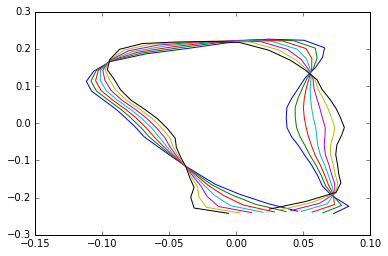

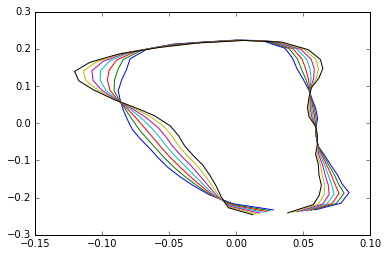

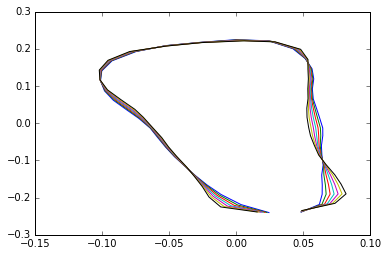

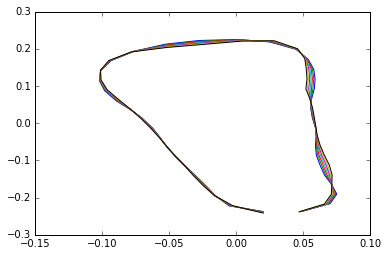

[ 0.01179891  0.00738997  0.00198041]


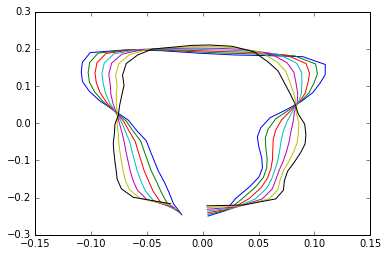

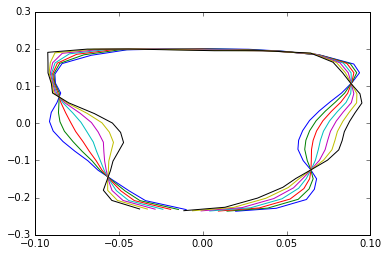

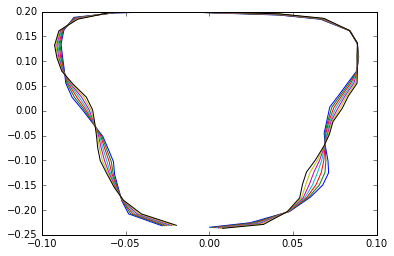

[ 0.01097533  0.00421272  0.00162955  0.00093237]


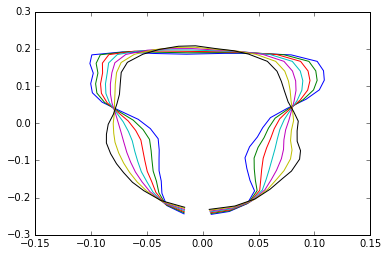

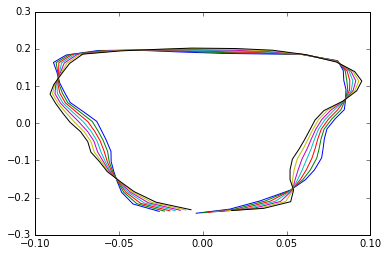

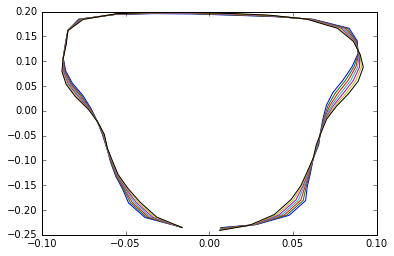

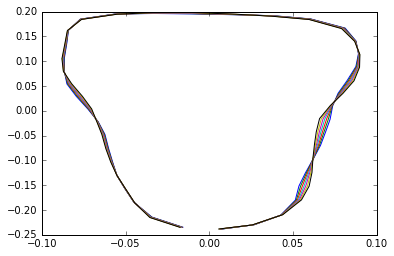

[ 0.01210255  0.00464385  0.00199517  0.00183703]


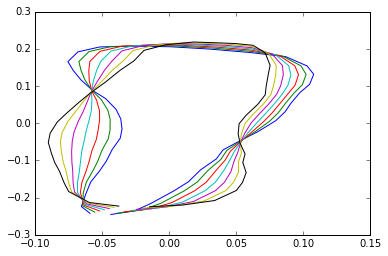

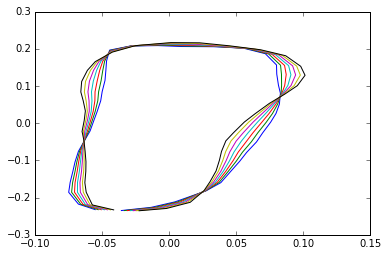

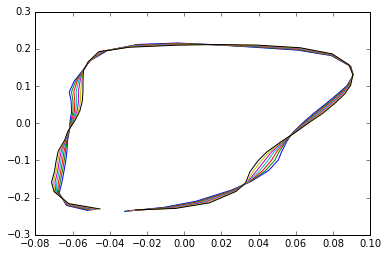

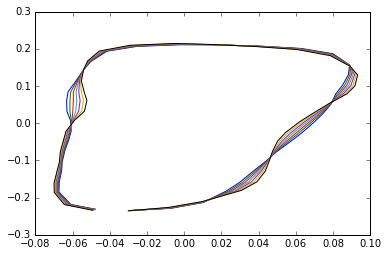

[ 0.00822421  0.00553424  0.00206403  0.0014572 ]


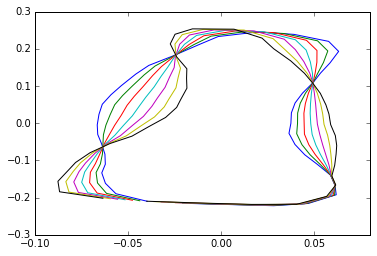

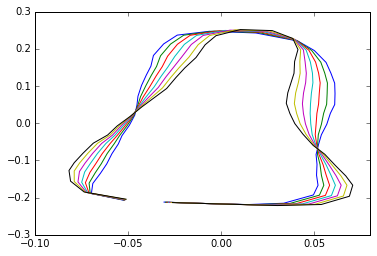

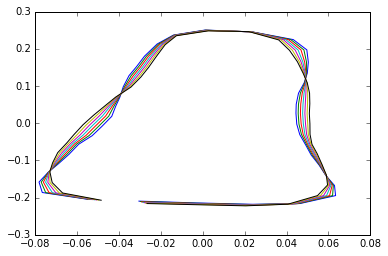

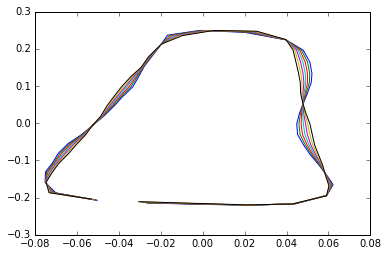

[ 0.00546299  0.00293355  0.00194326  0.00135036]


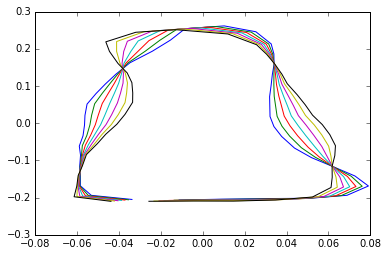

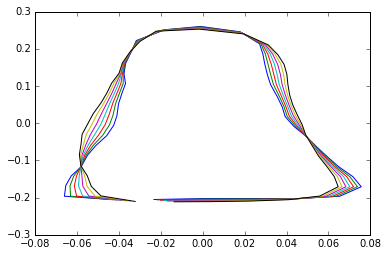

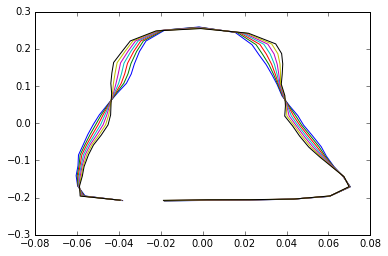

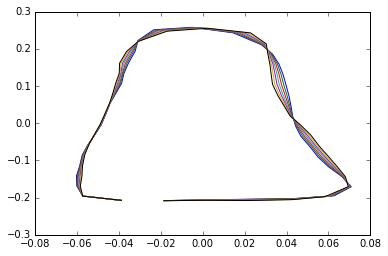

[ 0.00880995  0.00490146  0.00200119  0.00073898]


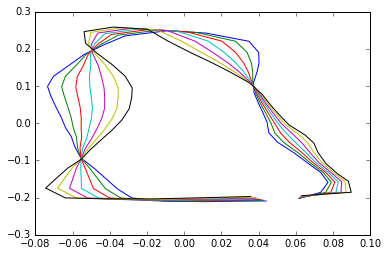

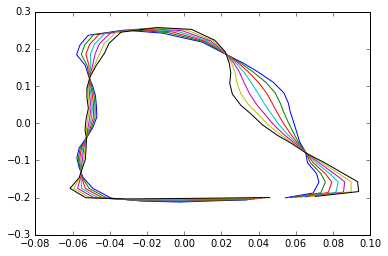

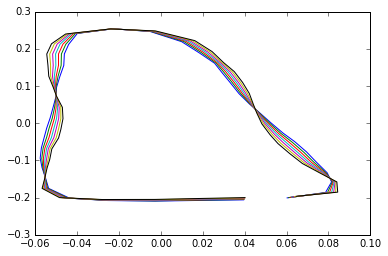

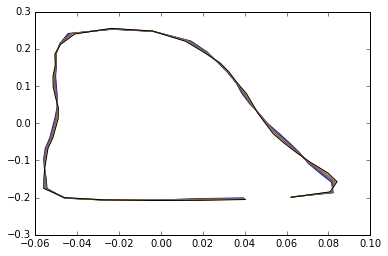

[ 0.01008595  0.00646907  0.00243656]


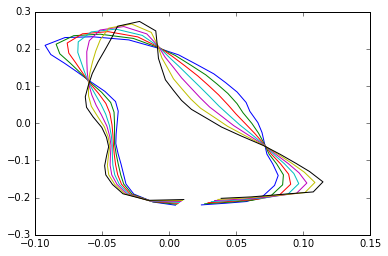

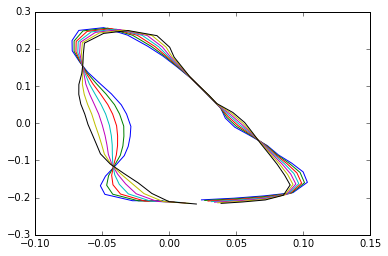

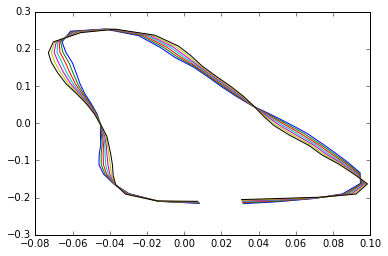

In [45]:
#show(images['1'])
#for index in range(8):
#    shapes=extractLandmarksForIncisorByIndex(landmarks,index)
#    centeredShapes = []
#    for shape in shapes:
#        cshape,mu=centerShape(shape)
#        centeredShapes.append(cshape)
#    plotShapes(centeredShapes)
#shapes=extractLandmarksForIncisorByIndex(landmarks,3)
#cshapes=[]
#for shape in shapes:
#    cshape,_=centerShape(shape)
#    cshapes.append(cshape)
#plotShapes(cshapes)
#ashape,_=alignAtoBProcrustes(cshapes[6],cshapes[1])
#plotShapes([cshapes[6],cshapes[1]])
#plotShapes([ashape,cshapes[1]])
#newshapes,meanShape,t=gpa(shapes)
#plotShapes([meanShape])
#plotShapes(newshapes)
#ashapemat=[]
#ashapemean=[]
for i in range(8):
    shapes=extractLandmarksForIncisorByIndex(landmarks,i)
    #newshapes,meanShape,t=gpa(shapes)
    #print 'Completed gpa of incisor ' + str(i) + ' in ' + str(t) + ' iterations '
    #plotShapes([meanShape])
    #ashapemat.append(newshapes)
    #ashapemean.append(meanShape)
    #X=prePCA(shapes)
    #l,W,mu=pcaV(X,0.9)
    #print W.shape
    #print l
    model = ASM(shapes,0.9)
    print model.getLambdas()
    modes=model.getModes()
    for j in range(len(model.getLambdas())):
        plotShapes(modes[j])   
    
    